<a href="https://colab.research.google.com/github/Chin-I/finlab_crypto/blob/master/lppl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 股市泡沫檢測器 - FinLab
這是一個泡沫檢測器，只要輸入[yahoo finance](https://finance.yahoo.com/)上找到的股票代號，即可查看該股票是否有泡沫，或是反泡沫。此程式碼使用 [lppls package](https://github.com/Boulder-Investment-Technologies/lppls) 讓我們非常方便的來使用 LPPL 這個數學工具。

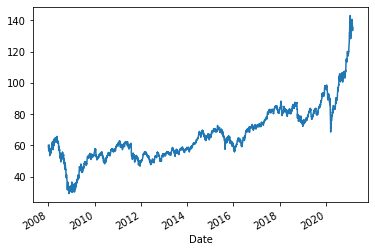

In [ ]:
#@title 下載歷史價格

try:
    import yfinance as yf
except:
    !pip install lppls > log.txt
    !pip install yfinance > log.txt

asset_symbol = "0050.TW" #@param {type:"string"}

import yfinance as yf
stock = yf.Ticker(asset_symbol)

# get historical market data
data = stock.history(period="max")

data.Close.plot()

crash date: 2021-02-01
( b < 0   )  10699.551789493797
(|c| < 1  )  2477.84300054142
(0 < m < 1)  -4.063786773188845


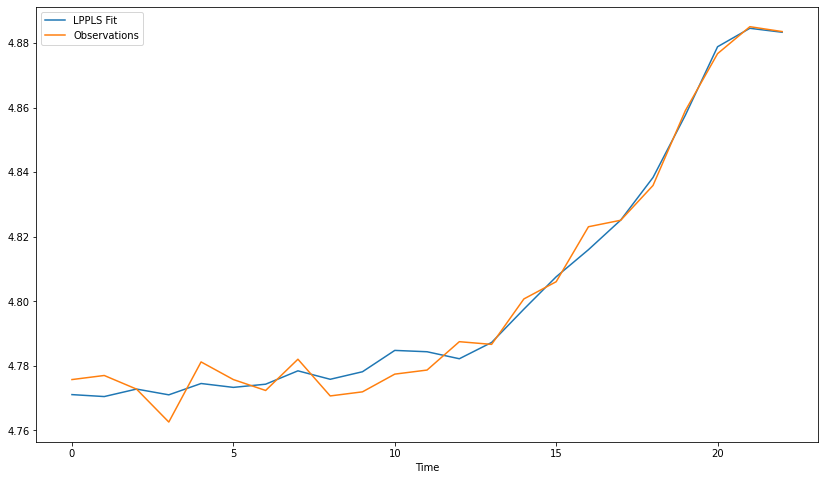

In [ ]:
#@title LPPL 分析
variable_name = "2021-01-12" #@param {type:"date"}
ndates = 23 #@param {type:"slider", min:0, max:500, step:1}

from lppls import lppls, data_loader
import numpy as np
import pandas as pd
%matplotlib inline

latest_data = data.loc[:variable_name].iloc[-ndates:]

# convert index col to evenly spaced numbers over a specified interval
time = np.linspace(0, len(latest_data)-1, len(latest_data))

# create list of observation data, in this case, 
# daily adjusted close prices of the S&P 500
# use log price
price = np.log(latest_data['Close'].values)

# create Mx2 matrix (expected format for LPPLS observations)
observations = np.array([time, price])

# set the max number for searches to perform before giving-up
# the literature suggests 25
MAX_SEARCHES = 25

# instantiate a new LPPLS model with the S&P 500 dataset
lppls_model = lppls.LPPLS(observations=observations)

# fit the model to the data and get back the params
tc, m, w, a, b, c, c1, c2 = lppls_model.fit(observations, MAX_SEARCHES, minimizer='Nelder-Mead')

# visualize the fit
lppls_model.plot_fit()

# should give a plot like the following...


import datetime
crash_date = (latest_data.index[-1] - latest_data.index[0]) / len(latest_data) * tc + latest_data.index[0]
print(crash_date.strftime('crash date: %Y-%m-%d'))
print('( b < 0   ) ', b)
print('(|c| < 1  ) ', c)
print('(0 < m < 1) ', m)

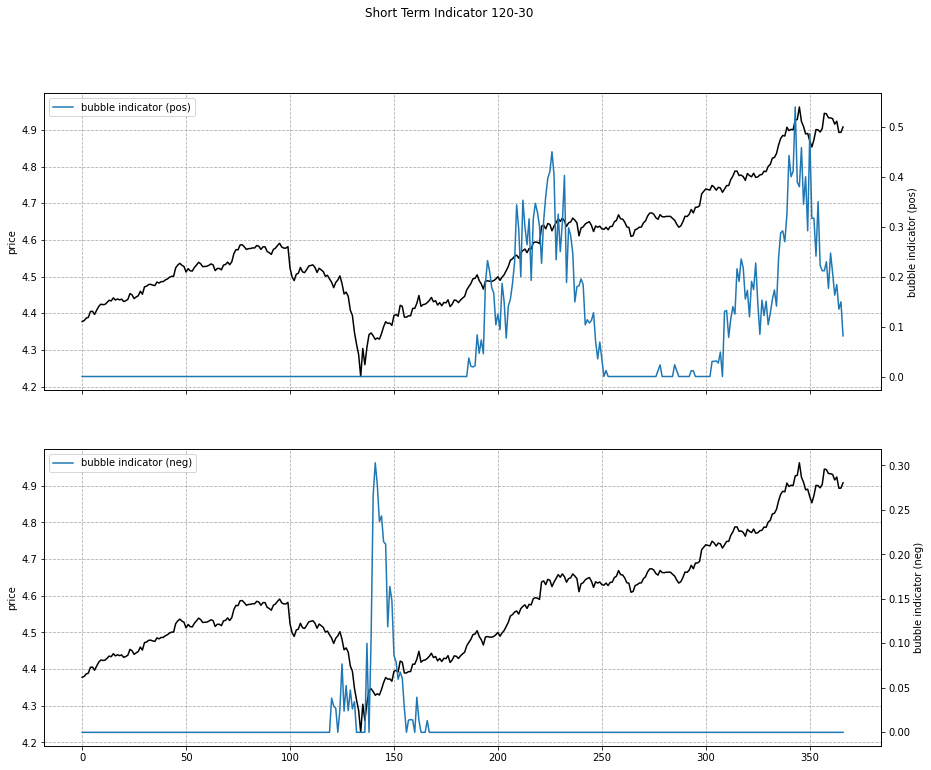

In [ ]:
#@title LPPLS
backtest_days = 367 #@param {type:"slider", min:0, max:1024, step:1}

latest_data = data.iloc[-backtest_days:]

# convert index col to evenly spaced numbers over a specified interval
time = np.linspace(0, len(latest_data)-1, len(latest_data))

# create list of observation data, in this case, 
# daily adjusted close prices of the S&P 500
# use log price
price = np.log(latest_data['Close'].values)

# create Mx2 matrix (expected format for LPPLS observations)
observations = np.array([time, price])

# set the max number for searches to perform before giving-up
# the literature suggests 25
MAX_SEARCHES = 25

# instantiate a new LPPLS model with the S&P 500 dataset
lppls_model = lppls.LPPLS(observations=observations)

# define custom filter condition
filter_conditions_config = [
  {'condition_1':[
      (0.0, 0.1), # tc_range
      (-1,1), # m_range
      (4,25), # w_range
      2.5, # O_min
      0.5, # D_min
  ]},
]

# compute the confidence indicator
res = lppls_model.mp_compute_indicator(
    workers=1, 
    window_size=120, 
    smallest_window_size=30, 
    increment=1, 
    max_searches=30,
    filter_conditions_config=filter_conditions_config
)

lppls_model.plot_confidence_indicators(res, condition_name='condition_1', title='Short Term Indicator 120-30')

# should give a plot like the following...

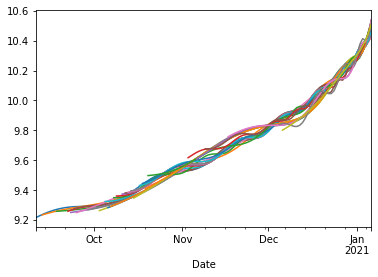

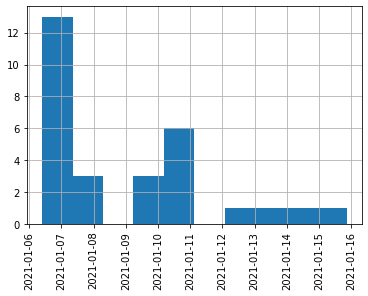

0     8.308170e+04
1     3.877241e+06
2     7.683647e+04
3     1.996046e+05
4     7.171006e+04
5     3.539827e+05
6     1.682399e+05
7     4.688690e+04
8     5.755490e+04
9     9.478918e+04
10    6.184617e+04
11    6.035442e+04
12    4.155147e+04
13    1.711908e+05
14    2.391518e+05
15    3.031267e+05
16    3.348380e+05
17    4.601080e+05
18    5.287066e+04
19    2.230456e+07
20    5.835428e+04
21    6.961992e+04
22    4.162999e+20
23    5.460104e+04
24    8.756363e+04
25    4.337211e+05
26    8.150284e+04
27    9.872304e+04
28    1.090963e+05
dtype: float64


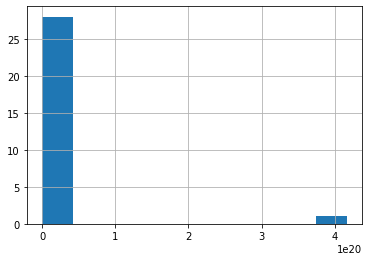

In [ ]:
crash_dates = []
crash_prices = []
for r in res[-1]:
    if r['qualified']['condition_1']:
        s = [lppls_model.lppls(t, r['tc'], r['m'], r['w'], r['a'], r['b'], r['c1'], r['c2']) for t in range(int(r['t1']), int(r['t2']))]
        pd.Series(s, index=latest_data.index[int(r['t1']):int(r['t2'])]).plot()
        crash_date = (latest_data.index[int(r['t2'])] - latest_data.index[int(r['t1'])]) / len(latest_data) * r['tc'] + latest_data.index[int(r['t1'])]
        crash_dates.append(crash_date)
        crash_prices.append(r['a'])

import matplotlib.pyplot as plt
plt.show()
pd.Series(crash_dates).hist(xrot=90)
plt.show()
import math
print(pd.Series(crash_prices).map(math.exp))

In [ ]:
import os
